# MARBERT v2 Fine-tuning Round 2: Refined Hyperparameters

This notebook refines hyperparameters based on Round 1 results.

**Best from Round 1**: Config 4 (Lower Learning Rate) with Basic Preprocessing achieved **83.76% F1**

**Key Findings**:
- Basic preprocessing > Advanced preprocessing
- Lower learning rate (2e-5) > Standard (5e-5)
- More epochs showed promise

**This Round**: Test refined configs around the winner:
- Learning rates: 1e-5, 1.5e-5, 2e-5, 2.5e-5, 3e-5
- Epochs: 3, 4, 5
- Combinations of best settings

**Dataset**: Basic preprocessing only (winner from Round 1)

**Model**: MARBERT v2 (UBC-NLP/MARBERTv2)

**Goal**: Push beyond 84% F1 score

## Setup: Install Required Packages

In [1]:
!pip install transformers torch scikit-learn pandas numpy tqdm accelerate -q

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Using device: cuda
GPU: Tesla T4
Memory: 14.74 GB


## Load Dataset (Basic Preprocessing Only)

In [3]:
# Load basic preprocessing dataset (winner from Round 1)
# Note: Update the path if running on Colab and data is uploaded
basic_path = 'arb_clean_basic.csv'

df_basic = pd.read_csv(basic_path)

print("="*80)
print("BASIC PREPROCESSING DATASET")
print("="*80)
print(f"Shape: {df_basic.shape}")
print(f"Columns: {list(df_basic.columns)}")
print(f"\nFirst few rows:")
print(df_basic.head(3))
print(f"\nClass distribution:")
print(df_basic['polarization'].value_counts())
print(f"Class balance: {df_basic['polarization'].value_counts(normalize=True).to_dict()}")

BASIC PREPROCESSING DATASET
Shape: (3380, 3)
Columns: ['id', 'text', 'polarization']

First few rows:
                                     id  \
0  arb_a2a60c8b4af3389e842d8ec31afb0eea   
1  arb_6723e56a672674a6c1d9b28b213c4a05   
2  arb_b0365d606edeee38ae6c025b1ca33e96   

                                                text  polarization  
0  احلام انتي ونعالي ومنو انتي حتي تقيمين الفناني...             1  
1  وره الكواليس تنيجج من وره بعير صطناعي علي فكرة...             1  
2  .خخخخ الملكه احلام فيها شذوذ شنو هل بوس والدلع...             1  

Class distribution:
polarization
0    1868
1    1512
Name: count, dtype: int64
Class balance: {0: 0.5526627218934911, 1: 0.44733727810650886}


## Split Dataset (90/10 Train/Test with Stratification)

In [4]:
# Split with stratification to maintain class balance
RANDOM_STATE = 42

train_df_basic, test_df_basic = train_test_split(
    df_basic,
    test_size=0.1,
    random_state=RANDOM_STATE,
    stratify=df_basic['polarization']
)

print("DATASET SPLIT:")
print(f"Train set size: {len(train_df_basic)} ({len(train_df_basic)/len(df_basic)*100:.1f}%)")
print(f"Test set size: {len(test_df_basic)} ({len(test_df_basic)/len(df_basic)*100:.1f}%)")
print(f"\nTrain class balance: {train_df_basic['polarization'].value_counts(normalize=True).to_dict()}")
print(f"Test class balance: {test_df_basic['polarization'].value_counts(normalize=True).to_dict()}")

DATASET SPLIT:
Train set size: 3042 (90.0%)
Test set size: 338 (10.0%)

Train class balance: {0: 0.5525969756738988, 1: 0.44740302432610124}
Test class balance: {0: 0.5532544378698225, 1: 0.4467455621301775}


## Prepare Datasets for Training

In [5]:
# Convert to HuggingFace Dataset format
train_dataset = Dataset.from_pandas(train_df_basic[['text', 'polarization']].rename(columns={'polarization': 'label'}))
test_dataset = Dataset.from_pandas(test_df_basic[['text', 'polarization']].rename(columns={'polarization': 'label'}))

print("✓ Datasets prepared")
print(f"Train dataset: {train_dataset}")
print(f"Test dataset: {test_dataset}")

✓ Datasets prepared
Train dataset: Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 3042
})
Test dataset: Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 338
})


## Helper Functions for Training and Evaluation

In [6]:
def tokenize_function(examples, tokenizer):
    """Tokenize the texts"""
    return tokenizer(examples['text'], truncation=True, padding=False, max_length=512)

def compute_metrics(eval_pred):
    """Compute metrics for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'f1': f1
    }

def evaluate_model(trainer, test_dataset, config_name):
    """Evaluate model and return detailed metrics"""
    # Get predictions
    predictions = trainer.predict(test_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    # Calculate metrics
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    cm = confusion_matrix(labels, preds)

    return {
        'config': config_name,
        'accuracy': accuracy,
        'f1': f1,
        'predictions': predictions,
        'confusion_matrix': cm,
        'true_labels': labels,
        'pred_labels': preds
    }

print("✓ Helper functions defined")

✓ Helper functions defined


## Training Configurations - Round 2

Refined configurations based on Round 1 winner (Lower LR + Basic Preprocessing)

In [7]:
# Define refined training configurations
training_configs = [
    {
        'name': 'Config 1: Winner from R1 (Baseline)',
        'num_train_epochs': 3,
        'per_device_train_batch_size': 16,
        'per_device_eval_batch_size': 32,
        'learning_rate': 2e-5,
        'warmup_steps': 500,
        'weight_decay': 0.01,
    },
    {
        'name': 'Config 2: Very Low LR',
        'num_train_epochs': 3,
        'per_device_train_batch_size': 16,
        'per_device_eval_batch_size': 32,
        'learning_rate': 1e-5,
        'warmup_steps': 500,
        'weight_decay': 0.01,
    },
    {
        'name': 'Config 3: Mid-Low LR',
        'num_train_epochs': 3,
        'per_device_train_batch_size': 16,
        'per_device_eval_batch_size': 32,
        'learning_rate': 1.5e-5,
        'warmup_steps': 500,
        'weight_decay': 0.01,
    },
    {
        'name': 'Config 4: Mid-High LR',
        'num_train_epochs': 3,
        'per_device_train_batch_size': 16,
        'per_device_eval_batch_size': 32,
        'learning_rate': 2.5e-5,
        'warmup_steps': 500,
        'weight_decay': 0.01,
    },
    {
        'name': 'Config 5: Higher LR',
        'num_train_epochs': 3,
        'per_device_train_batch_size': 16,
        'per_device_eval_batch_size': 32,
        'learning_rate': 3e-5,
        'warmup_steps': 500,
        'weight_decay': 0.01,
    },
    {
        'name': 'Config 6: Winner + 4 Epochs',
        'num_train_epochs': 4,
        'per_device_train_batch_size': 16,
        'per_device_eval_batch_size': 32,
        'learning_rate': 2e-5,
        'warmup_steps': 500,
        'weight_decay': 0.01,
    },
    {
        'name': 'Config 7: Winner + 5 Epochs',
        'num_train_epochs': 5,
        'per_device_train_batch_size': 16,
        'per_device_eval_batch_size': 32,
        'learning_rate': 2e-5,
        'warmup_steps': 500,
        'weight_decay': 0.01,
    },
    {
        'name': 'Config 8: Very Low LR + More Epochs',
        'num_train_epochs': 5,
        'per_device_train_batch_size': 16,
        'per_device_eval_batch_size': 32,
        'learning_rate': 1e-5,
        'warmup_steps': 500,
        'weight_decay': 0.01,
    },
    {
        'name': 'Config 9: Winner + More Warmup',
        'num_train_epochs': 3,
        'per_device_train_batch_size': 16,
        'per_device_eval_batch_size': 32,
        'learning_rate': 2e-5,
        'warmup_steps': 1000,
        'weight_decay': 0.01,
    },
    {
        'name': 'Config 10: Winner + Higher Weight Decay',
        'num_train_epochs': 3,
        'per_device_train_batch_size': 16,
        'per_device_eval_batch_size': 32,
        'learning_rate': 2e-5,
        'warmup_steps': 500,
        'weight_decay': 0.05,
    },
]

print("Training Configurations - Round 2:")
print("="*80)
for i, config in enumerate(training_configs, 1):
    print(f"\n{config['name']}")
    for key, value in config.items():
        if key != 'name':
            print(f"  {key}: {value}")
print("="*80)
print(f"\nTotal configurations to test: {len(training_configs)}")

Training Configurations - Round 2:

Config 1: Winner from R1 (Baseline)
  num_train_epochs: 3
  per_device_train_batch_size: 16
  per_device_eval_batch_size: 32
  learning_rate: 2e-05
  warmup_steps: 500
  weight_decay: 0.01

Config 2: Very Low LR
  num_train_epochs: 3
  per_device_train_batch_size: 16
  per_device_eval_batch_size: 32
  learning_rate: 1e-05
  warmup_steps: 500
  weight_decay: 0.01

Config 3: Mid-Low LR
  num_train_epochs: 3
  per_device_train_batch_size: 16
  per_device_eval_batch_size: 32
  learning_rate: 1.5e-05
  warmup_steps: 500
  weight_decay: 0.01

Config 4: Mid-High LR
  num_train_epochs: 3
  per_device_train_batch_size: 16
  per_device_eval_batch_size: 32
  learning_rate: 2.5e-05
  warmup_steps: 500
  weight_decay: 0.01

Config 5: Higher LR
  num_train_epochs: 3
  per_device_train_batch_size: 16
  per_device_eval_batch_size: 32
  learning_rate: 3e-05
  warmup_steps: 500
  weight_decay: 0.01

Config 6: Winner + 4 Epochs
  num_train_epochs: 4
  per_device_train_

## Train and Evaluate All Configurations

Now we'll train MARBERT v2 with each refined configuration

In [8]:
# Model name
model_name = "UBC-NLP/MARBERTv2"

# Store all results
all_results = []

print("\n" + "="*80)
print(f"Training MARBERT v2 with {len(training_configs)} refined configurations")
print("="*80)

for config in training_configs:
    print(f"\n{'='*80}")
    print(f"{config['name']}")
    print(f"{'='*80}")

    # Load fresh model for each configuration
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2
    )

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Tokenize datasets
    tokenized_train = train_dataset.map(
        lambda x: tokenize_function(x, tokenizer),
        batched=True
    )
    tokenized_test = test_dataset.map(
        lambda x: tokenize_function(x, tokenizer),
        batched=True
    )

    # Create data collator
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Set up training arguments
    training_args = TrainingArguments(
        output_dir=f'./results_r2_{config["name"].replace(" ", "_").replace(":", "").replace("(", "").replace(")", "")}',
        num_train_epochs=config['num_train_epochs'],
        per_device_train_batch_size=config['per_device_train_batch_size'],
        per_device_eval_batch_size=config['per_device_eval_batch_size'],
        learning_rate=config['learning_rate'],
        warmup_steps=config['warmup_steps'],
        weight_decay=config['weight_decay'],
        logging_dir=f'./logs_r2_{config["name"].replace(" ", "_").replace(":", "").replace("(", "").replace(")", "")}',
        logging_steps=100,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        seed=RANDOM_STATE
    )

    # Create Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        compute_metrics=compute_metrics,
        data_collator=data_collator
    )

    # Train
    print(f"\nTraining {config['name']}...")
    trainer.train()

    # Evaluate
    results = evaluate_model(trainer, tokenized_test, config['name'])
    all_results.append(results)

    print(f"\nResults:")
    print(f"  Accuracy: {results['accuracy']:.4f}")
    print(f"  F1 Score: {results['f1']:.4f}")

    # Clear GPU memory
    del model
    del trainer
    torch.cuda.empty_cache()

print("\n" + "="*80)
print("ALL TRAINING COMPLETED!")
print("="*80)


Training MARBERT v2 with 10 refined configurations

Config 1: Winner from R1 (Baseline)


config.json:   0%|          | 0.00/757 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]


Training Config 1: Winner from R1 (Baseline)...


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nuh-alsharafi (deepclean415445) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.675500,0.426010,0.807692,0.808034
2,0.374300,0.394718,0.810651,0.810523
3,0.258900,0.488974,0.813609,0.814124



Results:
  Accuracy: 0.8136
  F1 Score: 0.8141

Config 2: Very Low LR


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]


Training Config 2: Very Low LR...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.691400,0.548102,0.792899,0.793306
2,0.461900,0.394357,0.813609,0.813773
3,0.308300,0.420561,0.816568,0.817033



Results:
  Accuracy: 0.8166
  F1 Score: 0.8170

Config 3: Mid-Low LR


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]


Training Config 3: Mid-Low LR...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.686800,0.459902,0.822485,0.821770
2,0.405600,0.392852,0.804734,0.804456
3,0.274600,0.442866,0.819527,0.820038



Results:
  Accuracy: 0.8225
  F1 Score: 0.8218

Config 4: Mid-High LR


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]


Training Config 4: Mid-High LR...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.677300,0.397893,0.816568,0.817090
2,0.363900,0.390465,0.828402,0.828739
3,0.250900,0.514146,0.816568,0.817033



Results:
  Accuracy: 0.8284
  F1 Score: 0.8287

Config 5: Higher LR


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]


Training Config 5: Higher LR...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.672300,0.389881,0.819527,0.820026
2,0.355500,0.439833,0.810651,0.809035
3,0.231800,0.576832,0.813609,0.814100



Results:
  Accuracy: 0.8195
  F1 Score: 0.8200

Config 6: Winner + 4 Epochs


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]


Training Config 6: Winner + 4 Epochs...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.682100,0.414093,0.837278,0.837567
2,0.377600,0.382357,0.825444,0.825866
3,0.251200,0.471874,0.822485,0.822836
4,0.130400,0.796322,0.804734,0.805228



Results:
  Accuracy: 0.8373
  F1 Score: 0.8376

Config 7: Winner + 5 Epochs


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]


Training Config 7: Winner + 5 Epochs...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.682400,0.426657,0.831361,0.831188
2,0.386500,0.380572,0.810651,0.810865
3,0.272800,0.459144,0.810651,0.809677
4,0.154900,0.761744,0.819527,0.819850
5,0.077200,0.821227,0.831361,0.831663



Results:
  Accuracy: 0.8314
  F1 Score: 0.8317

Config 8: Very Low LR + More Epochs


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]


Training Config 8: Very Low LR + More Epochs...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.690200,0.566429,0.784024,0.783954
2,0.471500,0.397088,0.828402,0.828287
3,0.313800,0.405892,0.822485,0.822686
4,0.203400,0.487840,0.834320,0.834785
5,0.125800,0.602804,0.819527,0.820026



Results:
  Accuracy: 0.8343
  F1 Score: 0.8348

Config 9: Winner + More Warmup


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]


Training Config 9: Winner + More Warmup...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.690200,0.566429,0.784024,0.783954
2,0.471500,0.397088,0.828402,0.828287
3,0.313800,0.410290,0.813609,0.813416



Results:
  Accuracy: 0.8284
  F1 Score: 0.8283

Config 10: Winner + Higher Weight Decay


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]


Training Config 10: Winner + Higher Weight Decay...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.682100,0.414210,0.834320,0.834645
2,0.377500,0.384511,0.822485,0.822836
3,0.259400,0.476223,0.813609,0.814124



Results:
  Accuracy: 0.8343
  F1 Score: 0.8346

ALL TRAINING COMPLETED!


## Compare All Results

In [9]:
# Create comparison DataFrame
results_df = pd.DataFrame([
    {
        'Configuration': r['config'],
        'Accuracy': r['accuracy'],
        'F1 Score': r['f1']
    }
    for r in all_results
])

# Sort by F1 score
results_df = results_df.sort_values('F1 Score', ascending=False)

print("\n" + "="*80)
print("ROUND 2 RESULTS COMPARISON")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Find best configuration
best_result = results_df.iloc[0]
print(f"\n🏆 BEST CONFIGURATION (ROUND 2):")
print(f"   {best_result['Configuration']}")
print(f"   Accuracy: {best_result['Accuracy']:.4f}")
print(f"   F1 Score: {best_result['F1 Score']:.4f}")

# Compare with Round 1 winner
round1_best = 0.8376
improvement = best_result['F1 Score'] - round1_best
print(f"\n📊 COMPARISON WITH ROUND 1:")
print(f"   Round 1 Best: {round1_best:.4f}")
print(f"   Round 2 Best: {best_result['F1 Score']:.4f}")
print(f"   Improvement: {improvement:+.4f} ({improvement/round1_best*100:+.2f}%)")


ROUND 2 RESULTS COMPARISON
                          Configuration  Accuracy  F1 Score
            Config 6: Winner + 4 Epochs  0.837278  0.837567
    Config 8: Very Low LR + More Epochs  0.834320  0.834785
Config 10: Winner + Higher Weight Decay  0.834320  0.834645
            Config 7: Winner + 5 Epochs  0.831361  0.831663
                  Config 4: Mid-High LR  0.828402  0.828739
         Config 9: Winner + More Warmup  0.828402  0.828287
                   Config 3: Mid-Low LR  0.822485  0.821770
                    Config 5: Higher LR  0.819527  0.820026
                  Config 2: Very Low LR  0.816568  0.817033
    Config 1: Winner from R1 (Baseline)  0.813609  0.814124

🏆 BEST CONFIGURATION (ROUND 2):
   Config 6: Winner + 4 Epochs
   Accuracy: 0.8373
   F1 Score: 0.8376

📊 COMPARISON WITH ROUND 1:
   Round 1 Best: 0.8376
   Round 2 Best: 0.8376
   Improvement: -0.0000 (-0.00%)


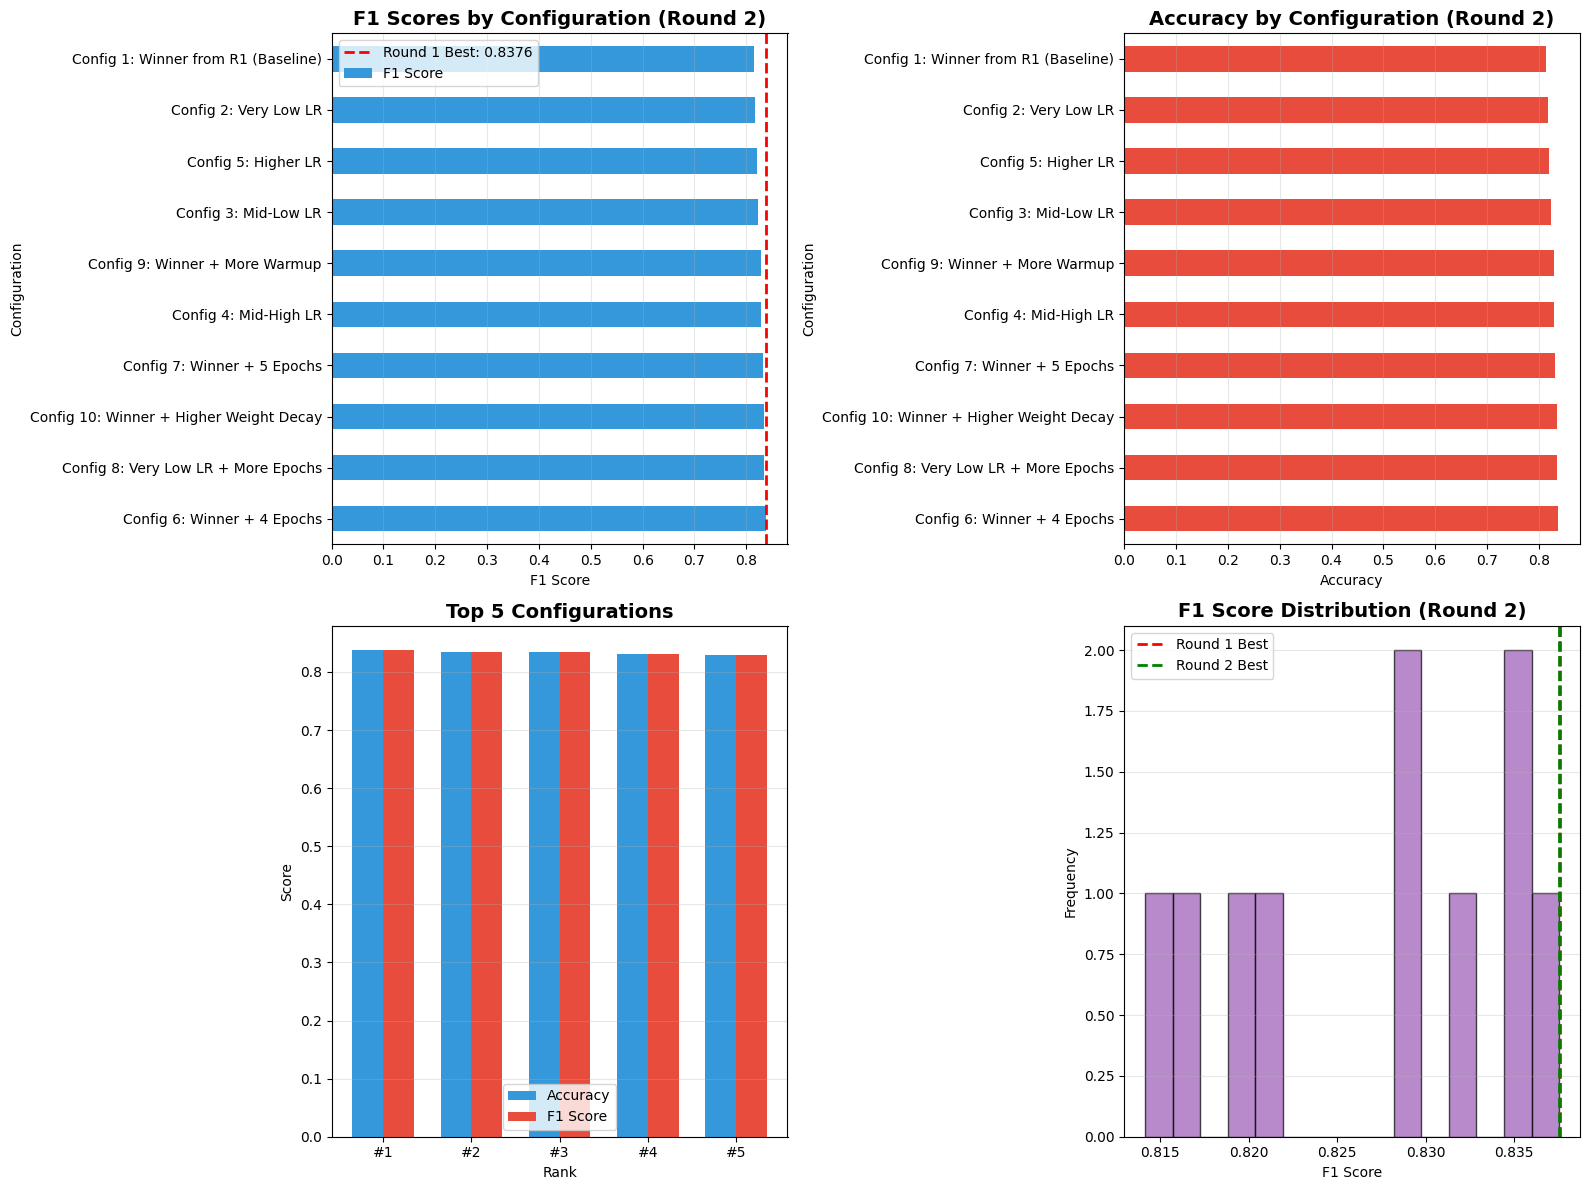


✓ Visualization complete


In [10]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. F1 Scores by Configuration
ax1 = axes[0, 0]
results_df.plot(x='Configuration', y='F1 Score', kind='barh', ax=ax1, color='#3498db', legend=False)
ax1.set_title('F1 Scores by Configuration (Round 2)', fontsize=14, fontweight='bold')
ax1.set_xlabel('F1 Score')
ax1.set_ylabel('Configuration')
ax1.axvline(x=round1_best, color='red', linestyle='--', linewidth=2, label=f'Round 1 Best: {round1_best:.4f}')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# 2. Accuracy Scores by Configuration
ax2 = axes[0, 1]
results_df.plot(x='Configuration', y='Accuracy', kind='barh', ax=ax2, color='#e74c3c', legend=False)
ax2.set_title('Accuracy by Configuration (Round 2)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Accuracy')
ax2.set_ylabel('Configuration')
ax2.grid(axis='x', alpha=0.3)

# 3. Top 5 Configurations
ax3 = axes[1, 0]
top5 = results_df.head(5)
x = range(len(top5))
width = 0.35
ax3.bar([i - width/2 for i in x], top5['Accuracy'], width, label='Accuracy', color='#3498db')
ax3.bar([i + width/2 for i in x], top5['F1 Score'], width, label='F1 Score', color='#e74c3c')
ax3.set_title('Top 5 Configurations', fontsize=14, fontweight='bold')
ax3.set_ylabel('Score')
ax3.set_xlabel('Rank')
ax3.set_xticks(x)
ax3.set_xticklabels([f"#{i+1}" for i in x])
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Score Distribution
ax4 = axes[1, 1]
ax4.hist(results_df['F1 Score'], bins=15, color='#9b59b6', alpha=0.7, edgecolor='black')
ax4.axvline(x=round1_best, color='red', linestyle='--', linewidth=2, label=f'Round 1 Best')
ax4.axvline(x=best_result['F1 Score'], color='green', linestyle='--', linewidth=2, label=f'Round 2 Best')
ax4.set_title('F1 Score Distribution (Round 2)', fontsize=14, fontweight='bold')
ax4.set_xlabel('F1 Score')
ax4.set_ylabel('Frequency')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete")

## Confusion Matrices for All Configurations

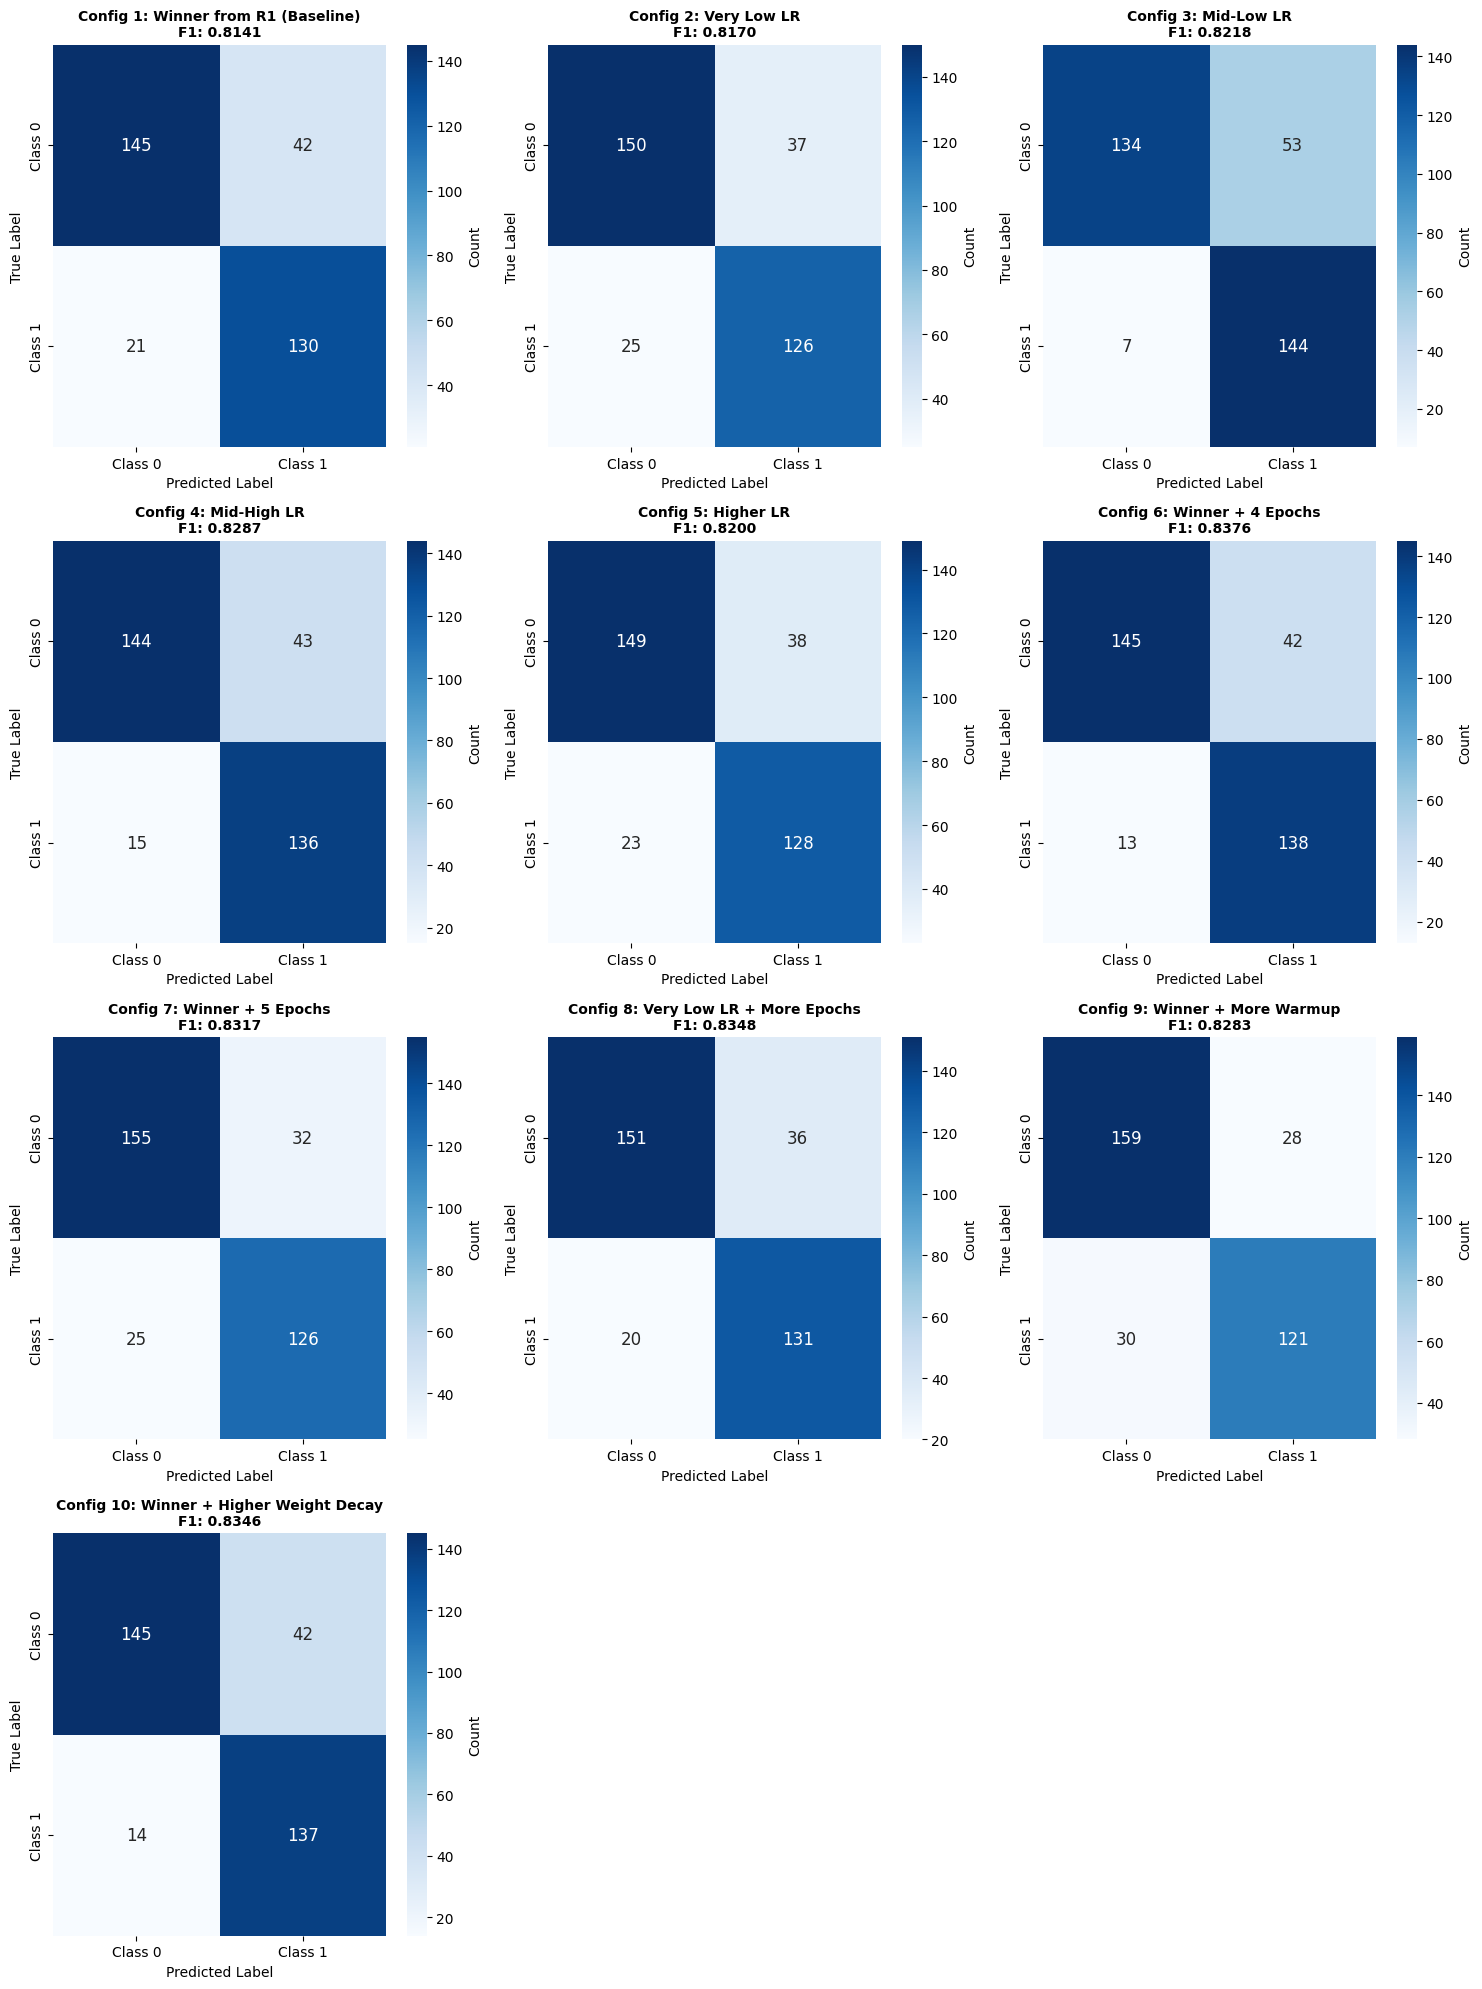


✓ Displayed 10 confusion matrices


In [11]:
# Create a grid of confusion matrices for all configurations
n_results = len(all_results)
n_cols = 3
n_rows = (n_results + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_results > 1 else [axes]

for idx, result in enumerate(all_results):
    ax = axes[idx]
    cm = result['confusion_matrix']

    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                cbar_kws={'label': 'Count'},
                annot_kws={'size': 12})

    # Set labels
    ax.set_title(f"{result['config']}\nF1: {result['f1']:.4f}",
                 fontsize=10, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.set_xticklabels(['Class 0', 'Class 1'])
    ax.set_yticklabels(['Class 0', 'Class 1'])

# Hide any unused subplots
for idx in range(n_results, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✓ Displayed {n_results} confusion matrices")

## Detailed Classification Reports

In [12]:
# Print classification reports for all configurations
for result in all_results:
    print("\n" + "="*80)
    print(f"{result['config']}")
    print("="*80)
    print(f"\nAccuracy: {result['accuracy']:.4f}")
    print(f"F1 Score: {result['f1']:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(result['true_labels'], result['pred_labels'],
                                target_names=['Class 0 (Negative)', 'Class 1 (Positive)']))
    print("\nConfusion Matrix:")
    print(result['confusion_matrix'])
    print(f"  [[TN={result['confusion_matrix'][0][0]}, FP={result['confusion_matrix'][0][1]}],")
    print(f"   [FN={result['confusion_matrix'][1][0]}, TP={result['confusion_matrix'][1][1]}]]")


Config 1: Winner from R1 (Baseline)

Accuracy: 0.8136
F1 Score: 0.8141

Classification Report:
                    precision    recall  f1-score   support

Class 0 (Negative)       0.87      0.78      0.82       187
Class 1 (Positive)       0.76      0.86      0.80       151

          accuracy                           0.81       338
         macro avg       0.81      0.82      0.81       338
      weighted avg       0.82      0.81      0.81       338


Confusion Matrix:
[[145  42]
 [ 21 130]]
  [[TN=145, FP=42],
   [FN=21, TP=130]]

Config 2: Very Low LR

Accuracy: 0.8166
F1 Score: 0.8170

Classification Report:
                    precision    recall  f1-score   support

Class 0 (Negative)       0.86      0.80      0.83       187
Class 1 (Positive)       0.77      0.83      0.80       151

          accuracy                           0.82       338
         macro avg       0.82      0.82      0.82       338
      weighted avg       0.82      0.82      0.82       338


Confusion Mat

## Save Misclassified Cases

In [13]:
# Collect all misclassified examples from all configurations
misclassified_data = []

for result in all_results:
    config_name = result['config']
    true_labels = result['true_labels']
    pred_labels = result['pred_labels']

    # Get the original test dataset
    test_df = test_df_basic.reset_index(drop=True)

    # Find misclassified indices
    misclassified_mask = true_labels != pred_labels
    misclassified_indices = np.where(misclassified_mask)[0]

    # Collect misclassified examples
    for idx in misclassified_indices:
        misclassified_data.append({
            'configuration': config_name,
            'text': test_df.iloc[idx]['text'],
            'true_label': int(true_labels[idx]),
            'predicted_label': int(pred_labels[idx]),
            'true_class': 'Positive' if true_labels[idx] == 1 else 'Negative',
            'predicted_class': 'Positive' if pred_labels[idx] == 1 else 'Negative',
            'error_type': 'False Positive' if (true_labels[idx] == 0 and pred_labels[idx] == 1) else 'False Negative',
            'text_length': len(test_df.iloc[idx]['text']),
            'word_count': len(test_df.iloc[idx]['text'].split())
        })

# Create DataFrame
misclassified_df = pd.DataFrame(misclassified_data)

# Save to CSV
output_file = 'misclassified_cases_round2.csv'
misclassified_df.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"\n{'='*80}")
print(f"MISCLASSIFICATION ANALYSIS (ROUND 2)")
print(f"{'='*80}")
print(f"\nTotal misclassified cases: {len(misclassified_df)}")
print(f"Saved to: {output_file}")

print(f"\nMisclassifications by Configuration:")
print(misclassified_df.groupby('configuration').size().sort_values(ascending=True))

print(f"\nMisclassifications by Error Type:")
print(misclassified_df.groupby('error_type').size())

print(f"\nAverage text length of misclassified examples:")
print(f"  Characters: {misclassified_df['text_length'].mean():.1f}")
print(f"  Words: {misclassified_df['word_count'].mean():.1f}")

print(f"\n✓ Misclassified cases saved successfully!")


MISCLASSIFICATION ANALYSIS (ROUND 2)

Total misclassified cases: 586
Saved to: misclassified_cases_round2.csv

Misclassifications by Configuration:
configuration
Config 6: Winner + 4 Epochs                55
Config 10: Winner + Higher Weight Decay    56
Config 8: Very Low LR + More Epochs        56
Config 7: Winner + 5 Epochs                57
Config 9: Winner + More Warmup             58
Config 4: Mid-High LR                      58
Config 3: Mid-Low LR                       60
Config 5: Higher LR                        61
Config 2: Very Low LR                      62
Config 1: Winner from R1 (Baseline)        63
dtype: int64

Misclassifications by Error Type:
error_type
False Negative    193
False Positive    393
dtype: int64

Average text length of misclassified examples:
  Characters: 106.7
  Words: 19.5

✓ Misclassified cases saved successfully!
